In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import gudhi
from pogo import Pogo
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from umap import UMAP,plot
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from scipy.spatial.distance import is_valid_dm
import seaborn as sns#; sns.set_theme()


/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/a/Desktop/ds/env/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
pogo=Pogo()

In [3]:
hf = h5py.File('Quake_Smart-seq2_Diaphragm/data.h5', 'r')

In [4]:
hf.keys()

<KeysViewHDF5 ['exprs', 'obs', 'obs_names', 'uns', 'var', 'var_names']>

In [5]:
exprs = hf.get('exprs')
np.array(exprs)

array(['data', 'indices', 'indptr', 'shape'], dtype='<U7')

In [6]:
obs = hf.get('obs')
np.array(obs)

array(['cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'channel',
       'cluster', 'dataset_name', 'donor', 'free_annotation', 'gender',
       'organ', 'organism', 'platform', 'region'], dtype='<U19')

In [7]:
ground_truth = np.array(obs.get('cluster'))
ground_truth.shape

(870,)

In [8]:
uns = hf.get('uns')
np.array(uns)

array(['expressed_genes', 'scmap_genes', 'seurat_genes'], dtype='<U15')

In [9]:
data = np.array(exprs.get('data'))

In [10]:
num_rows = np.array(exprs.get('shape'))[0]
num_columns = np.array(exprs.get('shape'))[1]

In [11]:
print(num_rows)
print(num_columns)

870
23341


In [12]:
indices = np.array(exprs.get('indices'))

In [13]:
indptr = np.array(exprs.get('indptr'))

In [14]:
matrix = csr_matrix((data, indices, indptr), shape=(num_rows, num_columns)).toarray()

In [15]:
matrix

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., 101.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,  67.,   0., ...,   0.,   0.,   0.]])

In [16]:
pca = PCA(n_components=2, random_state=0)
pca.fit(matrix)

PCA(n_components=2, random_state=0)

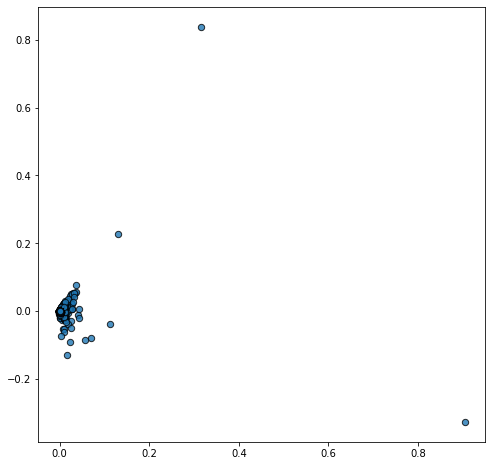

In [17]:
X=pca.components_.T[:,0]
y=pca.components_.T[:,1]
plt.figure(figsize=(8,8))
scatter = plt.scatter(X,y,
            s=40, 
            #c=c,
            marker="o",
            #cmap=cmap,
            norm=None,
            alpha=.8,
            edgecolor="k",
            vmin = 0)

plt.show()

In [18]:
Y = pdist(matrix, 'correlation')

In [19]:
Y.shape

(378015,)

In [20]:
mdist = squareform(Y, force='no', checks=True)

In [21]:
mdist.shape

(870, 870)

In [22]:
mdist

array([[0.        , 0.2481567 , 0.40205085, ..., 0.22494164, 0.23790942,
        0.22910211],
       [0.2481567 , 0.        , 0.11709152, ..., 0.14066171, 0.15410543,
        0.13934981],
       [0.40205085, 0.11709152, 0.        , ..., 0.33600546, 0.34593477,
        0.33774251],
       ...,
       [0.22494164, 0.14066171, 0.33600546, ..., 0.        , 0.06431486,
        0.06122598],
       [0.23790942, 0.15410543, 0.34593477, ..., 0.06431486, 0.        ,
        0.08066253],
       [0.22910211, 0.13934981, 0.33774251, ..., 0.06122598, 0.08066253,
        0.        ]])

In [23]:
is_valid_dm(mdist)

True

In [24]:
#Heatmap

#ax = sns.heatmap(mdist,cmap='Spectral')#, vmin=0, vmax=1, center=0.8)

#plt.title('Heatmap')
#plt.savefig('heatmap',dpi=100)

In [25]:
negmdist = np.negative(mdist)
similarity_matrix  = np.exp(negmdist)
kpca_2d_model = KernelPCA(n_components=2, kernel='precomputed',random_state=42)
kpca2 = kpca_2d_model.fit_transform(similarity_matrix)
X = kpca2[:,0]
y = kpca2[:,1]

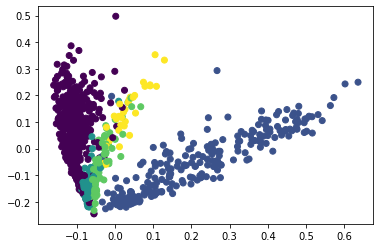

In [26]:
plt.scatter(X,y,c=ground_truth)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


Text(0.5, 1.0, 'Unlabeled UMAP Embedding in 2D')

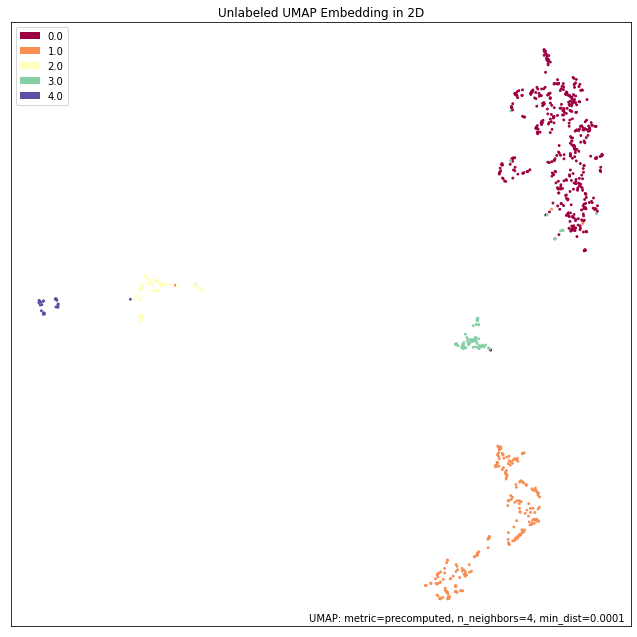

In [27]:
#Create 2-d umap dimensionality reduction embedding to visualize unsupervised models
umap_model_2d = UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4)
umap_embedding = umap_model_2d.fit_transform(mdist)
plot.points(umap_model_2d,labels=ground_truth)

plt.title('Unlabeled UMAP Embedding in 2D')

In [28]:
umap_embedding.shape

(870, 2)

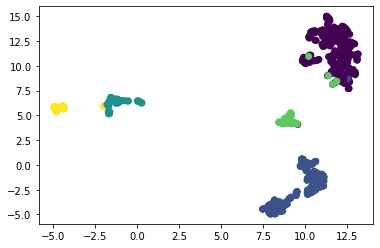

In [29]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1],c=ground_truth)

In [30]:
umap_model_33d = UMAP(metric='precomputed',min_dist=0.0001,n_neighbors=4,n_components=33)
umap_embedding_33d = umap_model_33d.fit_transform(mdist)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


usetex mode requires TeX.


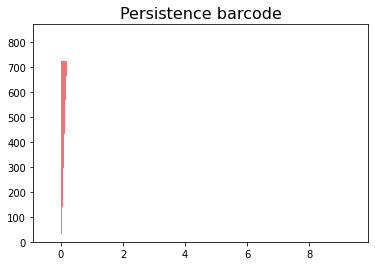

In [31]:
rips_complex = gudhi.RipsComplex(points=umap_embedding_33d)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
diag = simplex_tree.persistence()

gudhi.plot_persistence_barcode(diag)
plt.show()

In [32]:
persistence_module = simplex_tree.persistence()

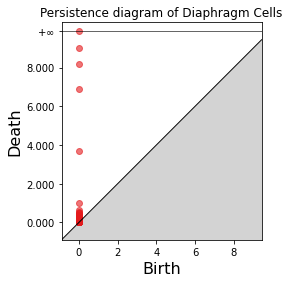

In [33]:
ax = gudhi.plot_persistence_diagram(persistence=persistence_module)
# We can modify the title, aspect, etc.
ax.set_title("Persistence diagram of Diaphragm Cells")
ax.set_aspect("equal")  # forces to be square shaped
plt.show()

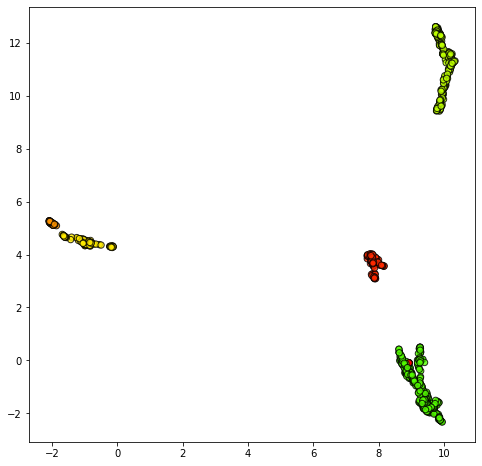

In [34]:

pogo.fit(umap_embedding_33d)
pogo.plot()

In [35]:
pogo.idx_

13103

In [36]:
pogo.labels_

array([0, 1, 1, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 4, 1, 1, 1, 4, 4, 0, 0, 0, 1, 1, 1, 4,
       3, 4, 0, 2, 0, 0, 0, 0, 0, 1, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 4, 1, 1,
       4, 4, 3, 2, 0, 0, 0, 0, 1, 1, 4, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 4,
       3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 4, 4, 1, 1, 4, 3, 2, 2, 0, 0, 1, 1, 4, 4, 2, 2, 3,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0,
       1, 0, 0, 0, 0, 0, 5, 0, 0, 1, 1, 1, 4, 4, 1, 1, 4, 4, 3, 2, 3, 0,
       0, 0, 1, 1, 4, 0, 3, 3, 0, 0, 0, 0, 0, 0, 4, 4, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 4, 4,
       1, 1, 4, 4, 3, 2, 2, 0, 0, 1, 1, 4, 4, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 4,
       2, 1, 0, 4, 4, 0, 1, 1, 1, 0, 4, 0, 0, 0, 0,

In [37]:
pogo.candidates_

[29689,
 117061,
 13103,
 151328,
 9498,
 6231,
 167002,
 9010,
 5608,
 5959,
 8754,
 5398,
 4797,
 4351,
 5002,
 5143,
 4046,
 4695,
 3954,
 4141,
 3483,
 4533,
 3634,
 4218,
 3882,
 3587,
 3775,
 5352,
 3709,
 4301,
 5282,
 4635,
 5318,
 3751,
 3846,
 4615,
 3934,
 6203,
 4676,
 3823,
 4290,
 5130,
 4038,
 5268,
 3580,
 174729,
 57990,
 57749,
 58595,
 58594,
 58593,
 58592,
 58591,
 58590,
 58589,
 58588,
 58587,
 57732,
 58586,
 58585,
 58584,
 58583,
 57733,
 58582,
 57734,
 58596,
 57731,
 58597,
 58607,
 58613,
 57730,
 58612,
 58611,
 58610,
 58609,
 58608,
 58606,
 58598,
 58605,
 58604,
 58603,
 58602,
 58601,
 58600,
 58599,
 57735,
 58581,
 58580,
 57744,
 57741,
 58563,
 58562,
 58561,
 57742,
 58560,
 57743,
 58559,
 58565,
 57745,
 58558,
 58557,
 57746,
 57747,
 57748,
 58556,
 58564,
 57740,
 58579,
 58573,
 57736,
 58578,
 58577,
 58576,
 57737,
 58575,
 58574,
 58572,
 58566,
 58571,
 58570,
 58569,
 58568,
 58567,
 57738,
 57739,
 58614,
 58615,
 57729,
 58655,
 586

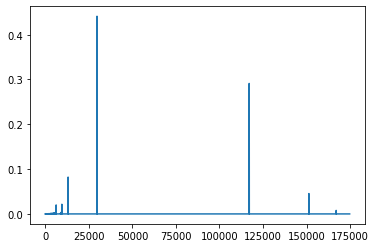

In [38]:
plt.plot(pogo.gap_vector_)

Maximum Silhouette: 13103


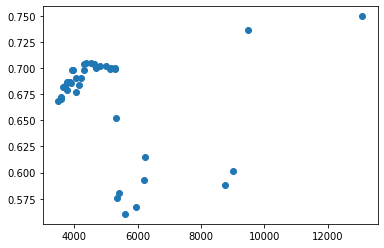

In [39]:
silhouette_indices, silhouette_array = pogo.plot_silhouette()

Maximum Silhouette Score: 13103


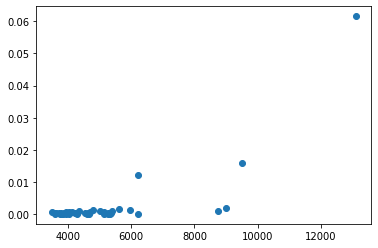

In [40]:
score_indices, score_array = pogo.plot_silhouette_score()

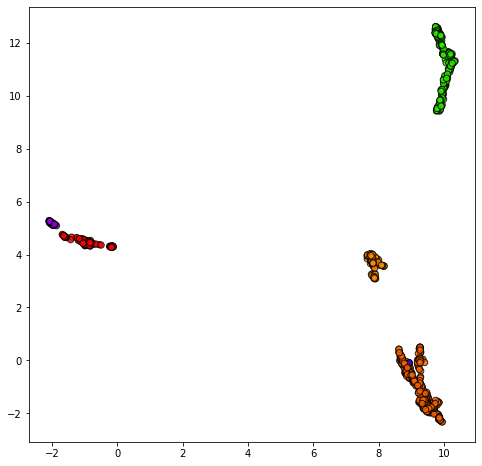

In [41]:
pogo.plot(13636)

Maximum Rand Score: 13103


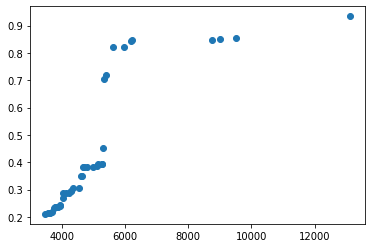

In [42]:
rand_indices, rand_array = pogo.plot_rand_score(ground_truth)


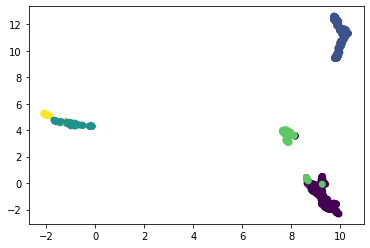

In [43]:
plt.scatter(umap_embedding_33d[:,0],umap_embedding_33d[:,1],c=ground_truth)